In [89]:
import pandas as pd

import math
import matplotlib
import numpy as np

# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from ai import cs
from keras.layers import Reshape, Softmax
from scipy.fft import fft, ifft, fftfreq, dct, idct
from scipy import signal

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, Embedding, LSTM, SimpleRNN
from keras.utils import np_utils

import random
import filterpy

In [3]:
input = open("data_noise_sinus/data_noise_sinus.txt").readlines()
input2 = open("data_noise_multitone/data_noise_multitone.txt").readlines()
input

['\n',
 '\n',
 '\n',
 '2022-12-02 22:20:21:565089  ->     Device used:genmet0\n',
 '\n',
 '2022-12-02 22:20:21:565089  ->     Theta   Phi             X              Y              Z                      |0>            |1>\n',
 '2022-12-02 22:20:21:628247  ->      36.0    56.9           0.3209906789   0.4923987072   0.8090169944           0.9510565163   0.1687547866 +0.2588693199 *i\n',
 '2022-12-02 22:20:22:180768  ->      35.6    48.9           0.3826732306   0.4386665601   0.8131007610           0.9521293927   0.2009565262 +0.2303607910 *i\n',
 '2022-12-02 22:20:22:733142  ->      38.3    26.6           0.5541780472   0.2775116939   0.7847763705           0.9446630009   0.2933204998 +0.1468839648 *i\n',
 '2022-12-02 22:20:23:284986  ->      38.7    60.6           0.3069339669   0.5447200375   0.7804304073           0.9435121640   0.1626550132 +0.2886661446 *i\n',
 '2022-12-02 22:20:23:840155  ->      38.1    38.2           0.4849018958   0.3815801654   0.7869350220           0.945234

In [4]:
def parse_line(line: str):
    strings = [x for x in line.split(" ") if x != "" and x != "->"][0:-1]
    strings = [float(x) if i > 1 else x for i, x in enumerate(strings)]
    datetime_str = strings[0] + 'T' + strings[1]
    datetime_str = datetime_str[:19] + "." + datetime_str[20:]
    strings = [pd.Timestamp(datetime_str)] + strings[2:]
    return strings


columns = ['datetime', 'Theta', 'Phi', 'X', 'Y', 'Z', '|0>', '|1> r', '|1> i']
data = [parse_line(l) for l in input[6:]]
data2 = [parse_line(l) for l in input2[6:]]

In [5]:
df = pd.DataFrame(data, columns=columns)
df2 = pd.DataFrame(data2, columns=columns)
df

,datetime,Theta,Phi,X,Y,Z,|0>,|1> r,|1> i
0,2022-12-02 22:20:21.628247,36.0,56.9,0.320991,0.492399,0.809017,0.951057,0.168755,0.258869
1,2022-12-02 22:20:22.180768,35.6,48.9,0.382673,0.438667,0.813101,0.952129,0.200957,0.230361
2,2022-12-02 22:20:22.733142,38.3,26.6,0.554178,0.277512,0.784776,0.944663,0.293320,0.146884
3,2022-12-02 22:20:23.284986,38.7,60.6,0.306934,0.544720,0.780430,0.943512,0.162655,0.288666
4,2022-12-02 22:20:23.840155,38.1,38.2,0.484902,0.381580,0.786935,0.945234,0.256498,0.201844
...,...,...,...,...,...,...,...,...,...
8699,2022-12-02 23:40:26.075369,38.7,61.0,0.303124,0.546850,0.780430,0.943512,0.160636,0.289795
8700,2022-12-02 23:40:26.627850,38.8,40.3,0.477891,0.405281,0.779338,0.943223,0.253329,0.214838
8701,2022-12-02 23:40:27.180213,42.9,31.1,0.582879,0.351615,0.732543,0.930737,0.313128,0.188891
8702,2022-12-02 23:40:27.732510,39.6,62.5,0.294330,0.565402,0.770513,0.940881,0.156412,0.300464


In [6]:
deltas = [(df["datetime"][i + 1] - df["datetime"][i]).total_seconds() for i in range(df.shape[0] - 2, 0, -1)]
average_delta = sum(deltas) / len(deltas)
average_delta

0.5522987566076781

In [7]:
df["datetime"][1] - df["datetime"][0]

Timedelta('0 days 00:00:00.552521')

In [8]:
class Filter:
    def filter_1d_array(self, array):
        raise NotImplemented


class EmptyFilter(Filter):
    def filter_1d_array(self, array):
        return array


class IIR(Filter):
    def __init__(self, r: float, start=None):
        self.r = r
        self.start = start

    def filter_1d_array(self, array):
        output = []
        if self.start is None:
            x = array[0]
        else:
            x = self.start
        for i in range(len(array)):
            x = self.r * x + (1 - self.r) * array[i]
            output.append(x)
        return output


class RunningAverage(Filter):
    def __init__(self, width: int):
        self.width = width

    def filter_1d_array(self, array):
        f = np.array([1 for _ in range(self.width)])
        return signal.convolve(f, array)


class Gaussian(Filter):
    def __init__(self, width: int, std_dev: float):
        self.width = width
        self.std_dev = std_dev

    def filter_1d_array(self, array):
        f = signal.windows.gaussian(self.width, self.std_dev)
        return signal.convolve(f, array)



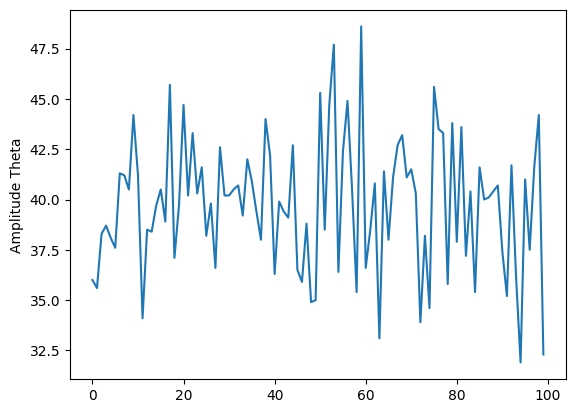

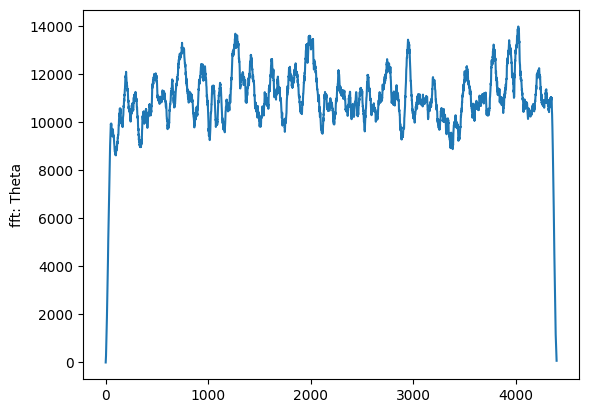

Average: 39.60754825367656
Average absolute deviation: 2.7356815087341504
std dev: 3.38896847376098


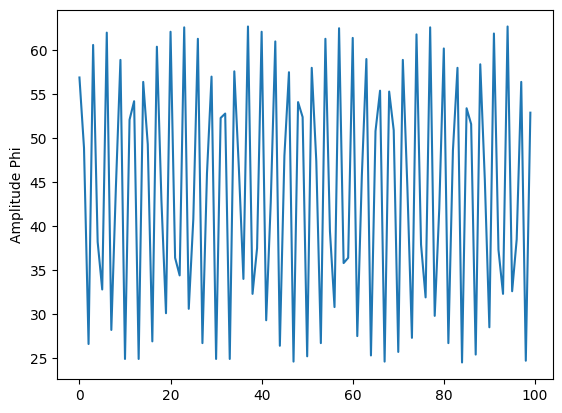

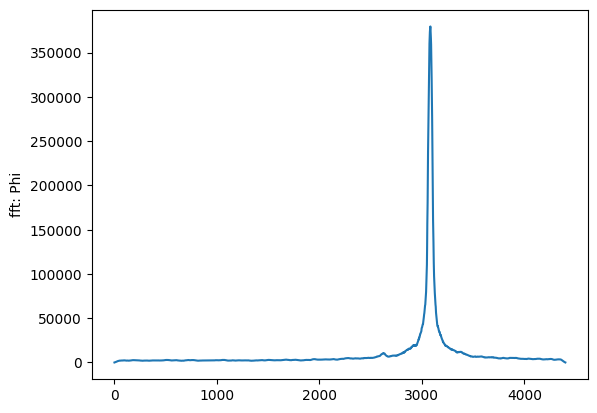

Average: 44.034673713235236
Average absolute deviation: 12.223820384728402
std dev: 13.556267778382004


[None, None]

In [9]:
def plot_with_fft(amplitude, name):
    avg = sum(amplitude) / len(amplitude)
    amplitude_offseted = list(map(lambda x: x - avg, amplitude))
    amplitude_fft = fft(amplitude_offseted)
    amplitude_fft_amplitude = np.sqrt(np.real(amplitude_fft) ** 2 + np.imag(amplitude_fft) ** 2)
    # N =len(amplitude_fft_amplitude)
    # xf = fftfreq(N, average_delta)[:N//2]
    amplitude_fft_amplitude = amplitude_fft_amplitude[0:len(amplitude_fft_amplitude) // 2]
    # f = IIR(0.9975)
    # f = RunningAverage(1)
    f = Gaussian(50, 20)
    amplitude_fft_real_filtered = f.filter_1d_array(amplitude_fft_amplitude)

    plt.plot(amplitude[:100])
    plt.ylabel(f"Amplitude {name}")
    plt.show()

    plt.plot(amplitude_fft_real_filtered)
    plt.ylabel(f"fft: {name}")
    plt.show()

    abs_dev = [abs(a - avg) for a in amplitude]
    square_dev = [(a - avg) ** 2 for a in amplitude]
    print(f"Average: {avg}")
    print(f"Average absolute deviation: {sum(abs_dev) / len(abs_dev)}")
    print(f"std dev: {math.sqrt(sum(square_dev) / len(square_dev))}")


[plot_with_fft([d[i] for d in data], df.columns[i]) for i in range(1, 3)]
# [plot_fft([d[i] for d in data], df.columns[i]) for i in range(1, 9)]

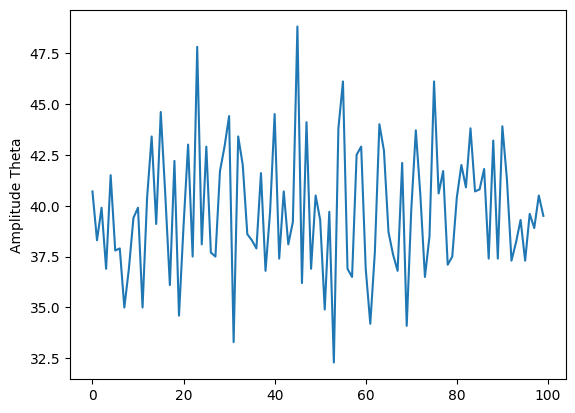

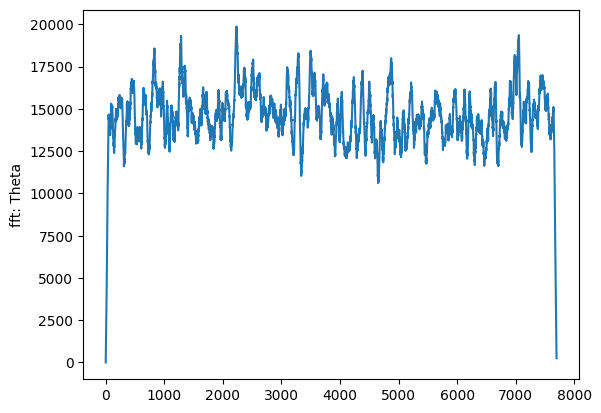

Average: 39.63496699993464
Average absolute deviation: 2.7382034272354545
std dev: 3.389891982154974


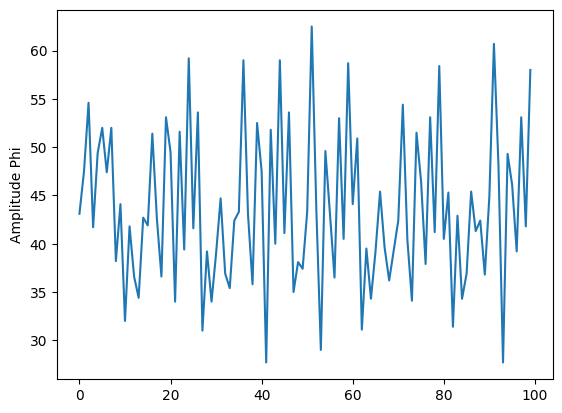

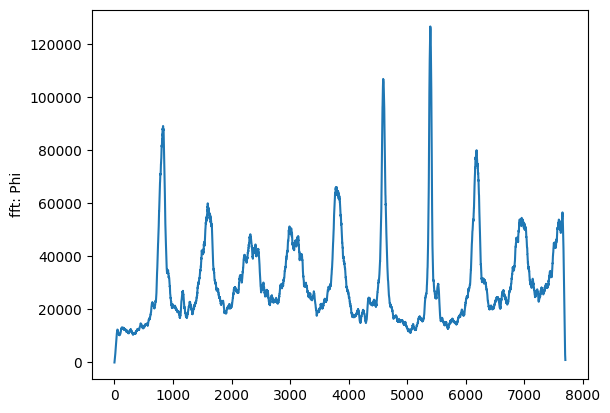

Average: 43.17478272234202
Average absolute deviation: 6.40186119665678
std dev: 8.008529476773695


[None, None]

In [10]:
[plot_with_fft([d[i] for d in data2], df.columns[i]) for i in range(1, 3)]

### Corellation

In [11]:
np.corrcoef([d[1] for d in data], [d[2] for d in data])

array([[ 1.        , -0.02485286],
       [-0.02485286,  1.        ]])

In [12]:
np.corrcoef([d[1] for d in data2], [d[2] for d in data2])

array([[ 1.        , -0.01848771],
       [-0.01848771,  1.        ]])

### My labels

In [13]:
N = len(data)
N

8704

In [14]:
my_theta = [random.gauss(mu=39.60754825367656, sigma=3.38896847376098) for _ in range(N)]
my_theta

[41.03831508750298,
 38.97104349604197,
 41.025673298896976,
 37.4201678076303,
 38.34965428257861,
 41.60535729739534,
 37.953229479194405,
 36.12330919519531,
 37.66413360089202,
 39.718978442294635,
 38.02352564559281,
 38.497242007807934,
 39.04879555124293,
 40.514742601735584,
 41.67003911355183,
 39.650301326095764,
 43.112274027479174,
 44.23518324513069,
 38.729812306854534,
 35.54578377248897,
 36.223028470933876,
 44.553313442797474,
 41.89807785182744,
 45.948152925136725,
 41.53809193638224,
 40.098524489899425,
 34.77469623555474,
 43.0005573193353,
 40.47317120506772,
 39.86254442017365,
 40.01966084824357,
 36.68429294674739,
 41.31039445275434,
 37.68870988620243,
 42.25006743700692,
 39.31594343116275,
 35.45417404088072,
 39.54143970324402,
 44.51272330345173,
 35.20927072286182,
 41.16251969234905,
 41.00645565106543,
 40.97434052698009,
 38.71716627738272,
 40.325337272240525,
 37.89048110481957,
 43.55181123173071,
 42.174765162796255,
 42.43233897771424,
 38.0824

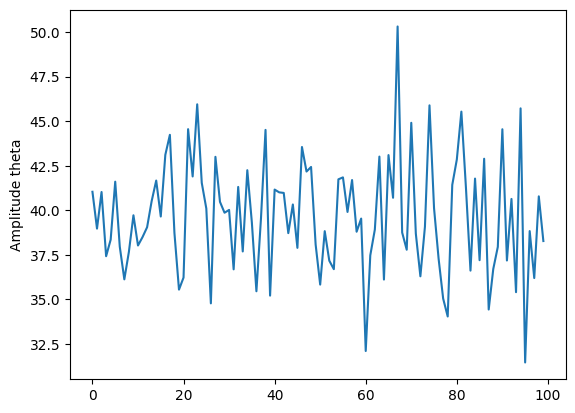

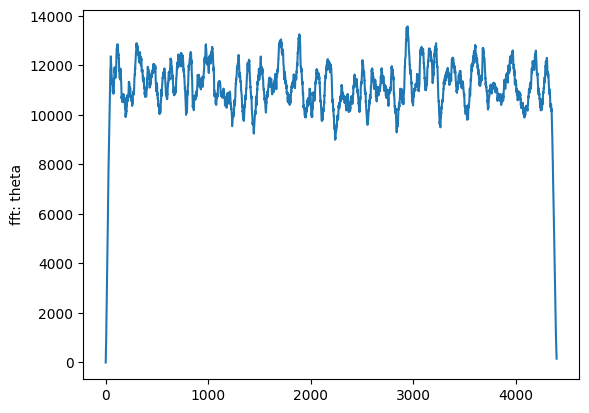

Average: 39.57631952976663
Average absolute deviation: 2.748386264601378
std dev: 3.424209380229655


In [15]:
plot_with_fft(my_theta, "theta")

In [16]:
T = average_delta
x = np.linspace(0.0, N * T, N, endpoint=False)
my_phi = np.sin(50.0 * 2.0 * np.pi * x) * 19 + 44.034673713235236
my_phi

array([44.03467371, 31.47531644, 62.88298688, ..., 35.50875923,
       61.65613166, 26.1153848 ])

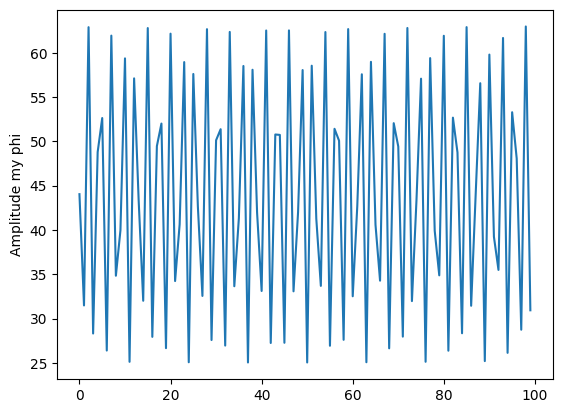

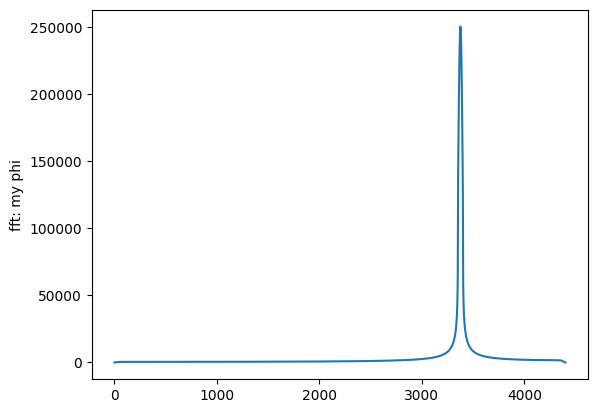

Average: 44.03336919082355
Average absolute deviation: 12.09567508166044
std dev: 13.435218170588112


In [17]:
plot_with_fft(my_phi, "my phi")

In [18]:
def plot(amplitude):
    f, ax = plt.subplots(1)
    ax.plot(amplitude)
    ax.set_ylim(ymin=0)
    plt.show(f)

### Dataset

In [114]:
# mixed_sources_xs_train = [x[7] for x in mixed_sources[:int(N*0.6)]]
# mixed_sources_xs_val = [x[7] for x in mixed_sources[int(N*0.6):int(N*0.8)]]
# mixed_sources_xs_test = [x[7] for x in mixed_sources[int(N*0.8):]]
#
# mixed_sources_ys_train = mixed_sources_labels[:int(N*0.6)]
# mixed_sources_ys_val = mixed_sources_labels[int(N*0.6):int(N*0.8)]
# mixed_sources_ys_test = mixed_sources_labels[int(N*0.8):]

N = min(len(data), len(data2))

xs_train_a = [x[7] for x in data[:int(N * 0.7)]]
xs_train_b = [x[7] for x in data2[:int(N * 0.7)]]
xs_test_a = [x[7] for x in data[int(N * 0.7):]]
xs_test_b = [x[7] for x in data2[int(N * 0.7):]]

# ys_train = [0 for i in range(int(N * 0.7))] + [1 for i in range(int(N * 0.7))]
# ys_train = np_utils.to_categorical(ys_train, 2)
# ys_test =[0 for i in range(int(N * 0.3))] + [1 for i in range(int(N * 0.3))]
# ys_test = np_utils.to_categorical(ys_test, 2)

window_size = 20

In [115]:
def into_windows(array, window_len):
    N = len(array)
    output = []
    for i in range(N - window_len + 1):
        output.append(array[i:i + window_len])
    return np.array(output)

In [116]:
xs_windowed_train_a = into_windows(xs_train_a, window_size)
xs_windowed_train_b = into_windows(xs_train_b, window_size)
xs_windowed_train =  np.concatenate((xs_windowed_train_a, xs_windowed_train_b),  axis=0)
xs_windowed_test_a = into_windows(xs_test_a, window_size)
xs_windowed_test_b = into_windows(xs_test_b, window_size)
xs_windowed_test = np.concatenate((xs_windowed_test_a, xs_windowed_test_b), axis=0)

xs_windowed_train /= 90
xs_windowed_test /= 90

In [117]:
ys_train = [0 for i in range(len(xs_windowed_train_a))] + [1 for i in range(len(xs_windowed_train_b))]
ys_train_categorical = np_utils.to_categorical(ys_train, 2)
ys_test =[0 for i in range(len(xs_windowed_test_a))] + [1 for i in range(len(xs_windowed_test_b))]
ys_test_categorical = np_utils.to_categorical(ys_test, 2)

In [118]:
np.array(xs_windowed_train)

array([[0.00187505, 0.00223285, 0.00325912, ..., 0.00213119, 0.00258939,
        0.00326411],
       [0.00223285, 0.00325912, 0.00180728, ..., 0.00258939, 0.00326411,
        0.00197707],
       [0.00325912, 0.00180728, 0.00284998, ..., 0.00326411, 0.00197707,
        0.00307344],
       ...,
       [0.00317588, 0.00274518, 0.00313534, ..., 0.00293759, 0.00304238,
        0.00302579],
       [0.00274518, 0.00313534, 0.00320482, ..., 0.00304238, 0.00302579,
        0.00284994],
       [0.00313534, 0.00320482, 0.00222612, ..., 0.00302579, 0.00284994,
        0.00233303]])

In [119]:
ys_train

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


# Train:

In [120]:
def evaluate(model, xs_windowed_test, ys_test_categorical):
    a = model.predict(xs_windowed_test[:1], verbose=0)
    b = model.predict(xs_windowed_test[-1:], verbose=0)
    eval_results = model.evaluate(xs_windowed_test, ys_test_categorical,verbose=0)

    predicted_classes = np.argmax(model.predict(xs_windowed_test, verbose=0), axis=-1)
    correct_indices = np.nonzero(predicted_classes == ys_test)[0]
    incorrect_indices = np.nonzero(predicted_classes != ys_test)[0]

    print(f"0: {a}")
    print(f"1: {b}")
    print({k:v for k, v in zip(model.metrics_names, eval_results)})
    print(f"correct: {len(correct_indices)} incorrect: {len(incorrect_indices)}")

## WIndowed input and output dense

In [127]:
ys_train_windowed = [0 for i in range(int(N * 0.7))] + [1 for i in range(int(N * 0.7))]
ys_train_windowed = np_utils.to_categorical(ys_train_windowed, 2)
ys_test_windowed =[0 for i in range(int(N * 0.3))] + [1 for i in range(int(N * 0.3))]
ys_test_windowed = np_utils.to_categorical(ys_test_windowed, 2)

In [128]:
model = Sequential()
model.add(Dense(512, input_shape=(window_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2*window_size))
model.add(Reshape((window_size, 2)))
model.add(Softmax(axis=2)) # w celu zapewnienia rozkładu wyjść sumującego się do 1

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               10752     
                                                                 
 activation_30 (Activation)  (None, 512)               0         
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 activation_31 (Activation)  (None, 512)               0         
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 40)              

In [131]:
model.fit(xs_windowed_train, ys_train_windowed,
          batch_size=128, epochs=16,
          verbose=1,
          validation_data=(xs_windowed_test, ys_test_windowed))

ValueError: Data cardinality is ambiguous:
  x sizes: 12146
  y sizes: 12184
Make sure all arrays contain the same number of samples.

## Windowed input and single output dense

In [68]:
model = Sequential()
model.add(Dense(256, input_shape=(window_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [69]:
# model.summary()

In [71]:
model.fit(xs_windowed_train, ys_train_categorical,
          batch_size=128, epochs=128,
          verbose=1,
          validation_data=(xs_windowed_test, ys_test_categorical))

Epoch 1/128
95/95 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.8369 - val_loss: 0.1156 - val_accuracy: 0.9224
Epoch 2/128
95/95 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.8323 - val_loss: 0.1243 - val_accuracy: 0.8992
Epoch 3/128
95/95 [==============================] - 0s 3ms/step - loss: 0.1352 - accuracy: 0.8412 - val_loss: 0.1108 - val_accuracy: 0.9181
Epoch 4/128
95/95 [==============================] - 0s 3ms/step - loss: 0.1344 - accuracy: 0.8424 - val_loss: 0.0934 - val_accuracy: 0.9371
Epoch 5/128
95/95 [==============================] - 0s 3ms/step - loss: 0.1349 - accuracy: 0.8378 - val_loss: 0.0872 - val_accuracy: 0.9383
Epoch 6/128
95/95 [==============================] - 0s 3ms/step - loss: 0.1348 - accuracy: 0.8369 - val_loss: 0.0897 - val_accuracy: 0.9359
Epoch 7/128
95/95 [==============================] - 0s 3ms/step - loss: 0.1314 - accuracy: 0.8416 - val_loss: 0.0889 - val_accuracy: 0.9325
Epoch 8/128
9

KeyboardInterrupt: 

In [67]:
evaluate(model, xs_windowed_test, ys_test_categorical)

0: [[0.86487716 0.13512284]]
1: [[0.0322787 0.9677213]]
{'loss': 0.023379048332571983, 'accuracy': 0.9765803813934326}
correct: 11509 incorrect: 276
276


## Small FFT input and single putput dense

In [72]:
def convertToFFT(array):
    return tf.abs(tf.signal.rfft(array))

In [74]:
xs_windowed_train_fft = np.array([convertToFFT(x) for x in xs_windowed_train])
xs_windowed_test_fft = np.array([convertToFFT(x) for x in xs_windowed_test])
window_size_fft = 20 // 2 + 1

In [75]:
model = Sequential()
model.add(Dense(128, input_shape=(window_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout helps protect the model from memorizing or "overfitting" the training data

model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
# model.add(Softmax())
model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [76]:
# model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               2688      
                                                                 
 activation_9 (Activation)   (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 activation_10 (Activation)  (None, 16)                0         
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [83]:
model.fit(xs_windowed_train, ys_train_categorical,
          batch_size=256, epochs=64,
          verbose=1,
          validation_data=(xs_windowed_test, ys_test_categorical))

Epoch 1/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0208 - accuracy: 0.9783 - val_loss: 0.0045 - val_accuracy: 0.9980
Epoch 2/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9806 - val_loss: 0.0071 - val_accuracy: 0.9965
Epoch 3/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.9795 - val_loss: 0.0108 - val_accuracy: 0.9928
Epoch 4/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9799 - val_loss: 0.0053 - val_accuracy: 0.9976
Epoch 5/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9792 - val_loss: 0.0078 - val_accuracy: 0.9944
Epoch 6/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 0.9811 - val_loss: 0.0125 - val_accuracy: 0.9910
Epoch 7/64
48/48 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9795 - val_loss: 0.0065 - val_accuracy: 0.9959
Epoch 8/64
48/48 [==

In [84]:
evaluate(model, xs_windowed_test, ys_test_categorical)

0: [[0.9977794 0.0022206]]
1: [[0.02917144 0.97082853]]
{'loss': 0.005563805811107159, 'accuracy': 0.9959270358085632}
correct: 11737 incorrect: 48
48


## Windowed input and single output RNN

In [108]:
model = Sequential()
# model.add(SimpleRNN((window_size,), input_shape=(window_size,),
#                     activation="relu"))
# model.add(Dense(units=1, activation="relu"))
model.add(SimpleRNN(32, input_shape=(window_size,1)))
# model.add(LSTM(32, input_shape=(window_size,1)))
# model.add(LSTM(128, input_shape=(window_size,1), return_sequences=True))

model.add(Dense(2))
model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_21 (Dense)            (None, 2)                 66        
                                                                 
 activation_21 (Activation)  (None, 2)                 0         
                                                                 
Total params: 1,154
Trainable params: 1,154
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.fit(xs_windowed_train, ys_train_categorical,
          batch_size=1024, epochs=256,
          verbose=1,
          validation_data=(xs_windowed_test, ys_test_categorical))

Epoch 1/256


ValueError: in user code:

    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\engine\training.py", line 1028, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\engine\training.py", line 1122, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\metrics\base_metric.py", line 691, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\metrics\metrics.py", line 3669, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "C:\Users\Pawel\Documents\Python\masters\venv\lib\site-packages\keras\utils\metrics_utils.py", line 970, in sparse_categorical_matches
        matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 2 and 20 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](IteratorGetNext:1, Cast_19)' with input shapes: [?,2], [?,20].


In [110]:
evaluate(model, xs_windowed_test, ys_test_categorical)

0: [[0.99799263 0.00200742]]
1: [[9.885653e-04 9.990114e-01]]
{'loss': 0.03203166648745537, 'accuracy': 0.9563852548599243}
correct: 11271 incorrect: 514
514
